# Install Module

Installing Datasets Module and Updating Transformers to the latest version by offline package resources

In [ ]:
! pip install ../input/chaii-python-module-installers/xxhash-2.0.2-cp37-cp37m-manylinux2010_x86_64.whl
! pip install ../input/chaii-python-module-installers/datasets-1.11.0-py3-none-any.whl
! pip install -U --no-build-isolation --no-deps ../input/chaii-python-module-installers/transformers_master/ -qq

# Importing Libraries

In [ ]:
import os
import sys
sys.path.append("../input/tez-lib/")
import tez
import torch
import random
import argparse
import collections
import transformers
import numpy as np
import pandas as pd
from torch import nn
from tqdm.auto import tqdm
from datasets import Dataset
from functools import partial
from tez import enums
from tez.callbacks import Callback
from IPython.display import display, HTML
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from transformers import default_data_collator
from string import punctuation

## Pytorch Custom Dataset

Link: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

The below examples is limited to create a custom Image Dataset however the code structure can be re-initialized to build a text based custom dataset also

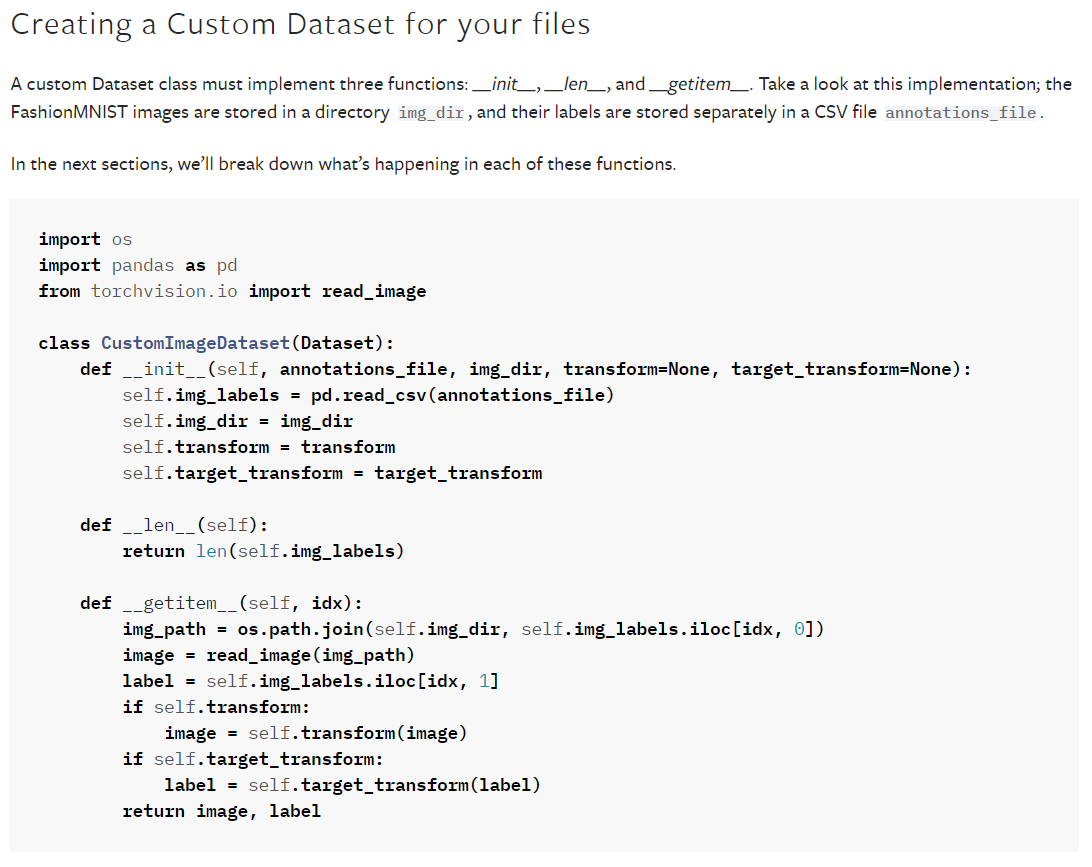

In [ ]:
class ChaiiCustomDataset:
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return {
            "ids": torch.tensor(self.data[item]["input_ids"], dtype=torch.long),
            "mask": torch.tensor(self.data[item]["attention_mask"], dtype=torch.long),
        }

## Pytorch Build the NN

Link: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

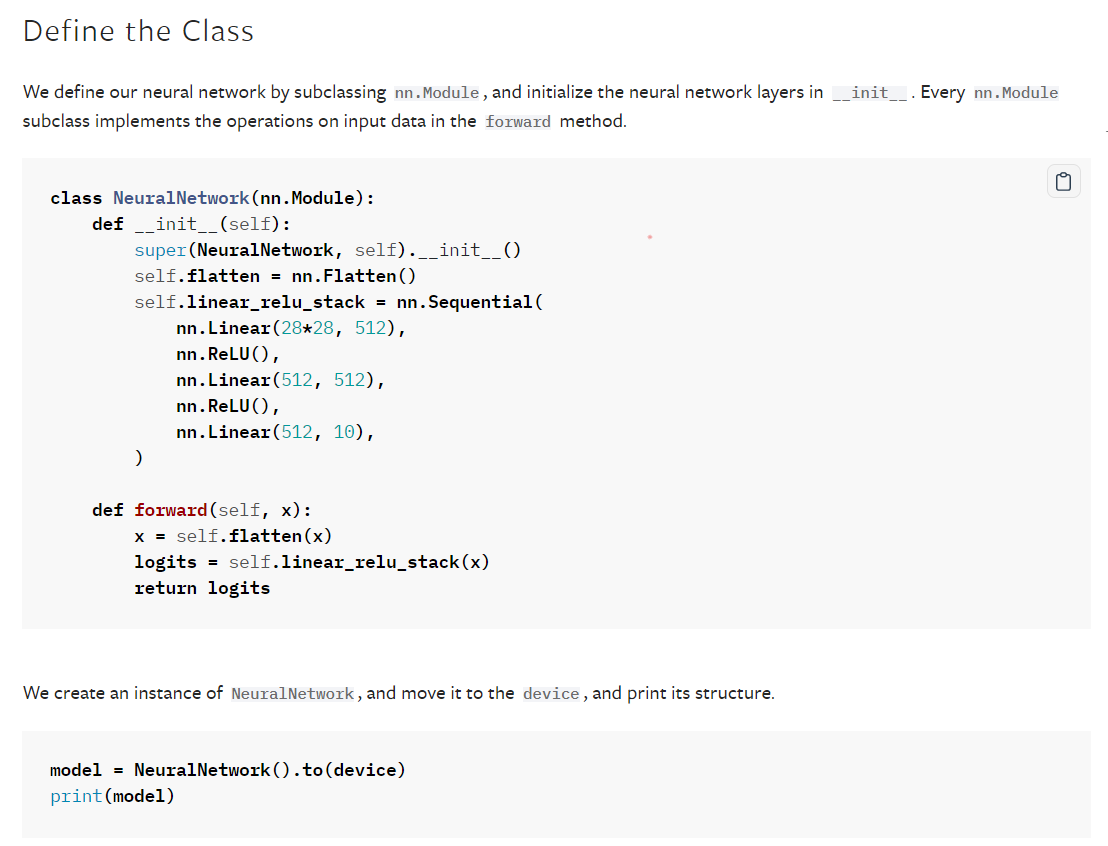

In [ ]:
class ChaiiNeuralModel(tez.Model):
    def __init__(self, model_name, num_train_steps, steps_per_epoch, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.steps_per_epoch = steps_per_epoch
        self.model_name = model_name
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"

        hidden_dropout_prob: float = 0.0
        layer_norm_eps: float = 1e-7

        config = transformers.AutoConfig.from_pretrained(model_name)
        config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout_prob": hidden_dropout_prob,
                "layer_norm_eps": layer_norm_eps,
                "add_pooling_layer": False,
            }
        )
        self.transformer = transformers.AutoModel.from_pretrained(model_name, config=config)
        self.output = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, ids, mask, token_type_ids=None, start_positions=None, end_positions=None):
        transformer_out = self.transformer(ids, mask)
        sequence_output = transformer_out[0]
        logits = self.output(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1).contiguous()
        end_logits = end_logits.squeeze(-1).contiguous()

        return (start_logits, end_logits), 0, {}

# Preparing the Tokenization Pipeline

In [ ]:
def prepare_train_features(examples,
                           tokenizer=None,
                           pad_on_right=None,
                           max_length=None,
                           doc_stride=None):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

def prepare_validation_features(examples,
                                tokenizer=None,
                                pad_on_right=None,
                                max_length=None,
                                doc_stride=None):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

def postprocess_qa_predictions(examples, 
                               tokenizer, 
                               features, 
                               raw_predictions, 
                               n_best_size=20, 
                               max_answer_length=30, 
                               squad_v2=False):
    all_start_logits, all_end_logits = raw_predictions
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    predictions = collections.OrderedDict()

    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    for example_index, example in enumerate(tqdm(examples)):
        feature_indices = features_per_example[example_index]

        min_null_score = None  # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            offset_mapping = features[feature_index]["offset_mapping"]

            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char:end_char],
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

def preprocess_answers(answer_info):
    ans_start_index = answer_info[0]
    ans_text = answer_info[1]
    return {
        'answer_start': [int(ans_start_index)],
        'text': [ans_text]
    }

In [ ]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Defining the early stopping class

In [ ]:
class EarlyStopping(Callback):
    def __init__(
        self,
        monitor,
        model_path,
        valid_dataframe,
        valid_data_loader,
        tokenizer,
        pad_on_right,
        max_length,
        doc_stride,
        patience=3,
        mode="min",
        delta=0.001,
        save_weights_only=False,
    ):
        self.monitor = monitor
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.save_weights_only = save_weights_only
        self.model_path = model_path
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

        if self.monitor.startswith("train_"):
            self.model_state = "train"
            self.monitor_value = self.monitor[len("train_") :]
        elif self.monitor.startswith("valid_"):
            self.model_state = "valid"
            self.monitor_value = self.monitor[len("valid_") :]
        else:
            raise Exception("monitor must start with train_ or valid_")

        self.valid_targets = valid_dataframe.answer_text.values
        self.valid_data_loader = valid_data_loader
        self.tokenizer = tokenizer
        valid_dataframe = valid_dataframe.drop(["answer_text", "answer_start"], axis=1)
        self.valid_dataset = Dataset.from_pandas(valid_dataframe)
        self.valid_features = self.valid_dataset.map(
            partial(
                prepare_validation_features,
                tokenizer=self.tokenizer,
                pad_on_right=pad_on_right,
                max_length=max_length,
                doc_stride=doc_stride,
            ),
            batched=True,
            remove_columns=self.valid_dataset.column_names,
        )

    def on_epoch_end(self, model):
        model.eval()
        tk0 = tqdm(self.valid_data_loader, total=len(self.valid_data_loader))
        start_logits = []
        end_logits = []

        for _, data in enumerate(tk0):
            with torch.no_grad():
                for key, value in data.items():
                    data[key] = value.to("cuda")
                output, _, _ = model(**data)
                start = output[0].detach().cpu().numpy()
                end = output[1].detach().cpu().numpy()
                start_logits.append(start)
                end_logits.append(end)

        start_logits = np.vstack(start_logits)
        end_logits = np.vstack(end_logits)

        valid_preds = postprocess_qa_predictions(
            self.valid_dataset, self.tokenizer, self.valid_features, (start_logits, end_logits)
        )
        epoch_score = np.mean([jaccard(x, y) for x, y in zip(self.valid_targets, valid_preds.values())])
        print(f"Jaccard Score = {epoch_score}")
        model.train()
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))
            if self.counter >= self.patience:
                model.model_state = enums.ModelState.END
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print("Validation score improved ({} --> {}). Saving model!".format(self.val_score, epoch_score))
            model.save(self.model_path, weights_only=self.save_weights_only)
        self.val_score = epoch_score

## Running the test dataset via each fold model and storing relevant positions  for each answer extracted

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("../input/chaii-pretrained-models/models/deepset/xlm-roberta-large-squad2")
pad_on_right = tokenizer.padding_side == "right"
max_length = 384
doc_stride = 128

test_data = pd.read_csv("../input/chaii-hindi-and-tamil-question-answering/test.csv")
test_dataset = Dataset.from_pandas(test_data)
test_features = test_dataset.map(
    partial(
        prepare_validation_features, 
        tokenizer=tokenizer,
        pad_on_right=pad_on_right, 
        max_length=max_length,
        doc_stride=doc_stride
    ),
    batched=True,
    remove_columns=test_dataset.column_names
)
test_feats_small = test_features.map(
    lambda example: example, remove_columns=['example_id', 'offset_mapping']
)

fin_start_logits = None
fin_end_logits = None

for fold_no in tqdm(range(10)):
    model = ChaiiNeuralModel(model_name="../input/chaii-pretrained-models/models/deepset/xlm-roberta-large-squad2", num_train_steps=0, steps_per_epoch=0, learning_rate=0)
    model.load("../input/chaii-trained-folds/chaii_trained_fold_%s.bin" %(str(fold_no)), weights_only=True)
    model.to("cuda")
    model.eval()
    data_loader = torch.utils.data.DataLoader(
        ChaiiCustomDataset(test_feats_small), 
        batch_size=32,
        num_workers=4,
        pin_memory=True,
        shuffle=False
    )

    start_logits = []
    end_logits = []

    for b_idx, data in enumerate(data_loader):
        with torch.no_grad():
            for key, value in data.items():
                data[key] = value.to("cuda")
            output, _, _ = model(**data)
            start = output[0].detach().cpu().numpy()
            end = output[1].detach().cpu().numpy()
            start_logits.append(start)
            end_logits.append(end)
    
    start_logits = np.vstack(start_logits)
    end_logits = np.vstack(end_logits)
    
    if fin_start_logits is None:
        fin_start_logits = start_logits
        fin_end_logits = end_logits
    else:
        fin_start_logits += start_logits
        fin_end_logits += end_logits
    
    del model
    torch.cuda.empty_cache()

## Dividing by total no of folds to get average out values

In [ ]:
fin_start_logits

In [ ]:
fin_end_logits

In [ ]:
fin_start_logits /= 10
fin_end_logits /= 10

In [ ]:
final_preds = postprocess_qa_predictions(test_dataset, tokenizer, test_features, (fin_start_logits, fin_end_logits))

In [ ]:
submission = []
for p1, p2 in final_preds.items():
    p2 = " ".join(p2.split())
    p2 = p2.strip(punctuation)
    submission.append((p1, p2))
    
sample = pd.DataFrame(submission, columns=["id", "PredictionString"])

test_data =pd.merge(left=test_data,right=sample,on='id')

In [ ]:
test_data

# Post Processing each predictions

In [ ]:
bad_starts = [".", ",", "(", ")", "-", "–",  ",", ";"]
bad_endings = ["...", "-", "(", ")", "–", ",", ";"]

tamil_ad = "கி.பி"
tamil_bc = "கி.மு"
tamil_km = "கி.மீ"
hindi_ad = "ई"
hindi_bc = "ई.पू"

cleaned_preds = []
for pred, context in test_data[["PredictionString", "context"]].to_numpy():
    if pred == "":
        cleaned_preds.append(pred)
        continue
    while any([pred.startswith(y) for y in bad_starts]):
        pred = pred[1:]
    while any([pred.endswith(y) for y in bad_endings]):
        if pred.endswith("..."):
            pred = pred[:-3]
        else:
            pred = pred[:-1]
    
    if any([pred.endswith(tamil_ad), pred.endswith(tamil_bc), pred.endswith(tamil_km), pred.endswith(hindi_ad), pred.endswith(hindi_bc)]) and pred+"." in context:
        pred = pred+"."

    cleaned_preds.append(pred)

In [ ]:
test_data["PredictionString"] = cleaned_preds

In [ ]:
test_data

In [ ]:
test_data[['id', 'PredictionString']].to_csv('submission.csv', index=False)